# Import libraries

In [1]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform, data
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import os
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")
plt.ion()   # interactive mode
from skimage.measure import regionprops
from skimage import filters
import torchvision.transforms.functional as TF
import torchvision
#import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import os
import PIL
#import cv2
import sys
import time
import imageio as iio
from skimage import filters
from skimage.color import rgb2gray  # only needed for incorrectly saved images
from skimage.measure import regionprops
from skimage.feature import canny
from scipy import ndimage as ndi
import shutil

In [2]:
import torch
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

In [3]:
depth = 2**8-1.
D_out = 441
C_in = 3 #how many views of one seed
mpl = [r'/home/cherepashkin/data/598_processing',  r'D:\data\seeds\598', r'D:\seva\598_processing'.replace('\\','/')] 
mpl = [s.replace('\\','/') for s in mpl]
i = 0
while not os.path.exists(mpl[i]):
    print(i)
    i+=1
mainpath = mpl[i]
print(mainpath)


0
1
D:/seva/598_processing


In [4]:
#><.,|\/

In [5]:
if torch.cuda.device_count()>1:
    device = torch.device('cuda:2')
elif torch.cuda.device_count()==1:
    device = torch.device('cuda')
else: 
    device = torch.device('cpu')
print(device)

cuda


## Timelapse printing

In [6]:
def ntime(s):
    m = 60
    l = [(s/m**2)%24, (s/m)%m, (s)%m]
    return([int(x) for x in l])
def coco(tl, ni, pt):
    sm = sum(tl)
    tt = 10*(pt)
    if sm > tt: 
        l = tuple(ntime(np.mean(tl)*ni-sum(tl)))
    else: 
        return([pt,'',''])
    if sm > tt and pt%14 != 13:
        return([pt+1,str("%02d:%02d:%02d," % l),''])
    elif sm > tt and pt%14 == 13:
        return([pt+1,str("%02d:%02d:%02d" % l),'\n'])

In [7]:
# if not(os.path.isfile('tmean.csv') and os.path.isfile(mainpath+'/sh_paramters.csv')):
#     cip = []
#     for root, directories, filenames in os.walk(mainpath): 
#         for filename in filenames:
#             if filename[-8:] == 'F_20.csv':
#                 cip.append(os.path.join(root,filename))
#     labels = np.zeros([len(cip),D_out])
#     for i in range(len(cip)):
#         labels[i,:] = torch.tensor(np.genfromtxt(cip[i], delimiter='\n'))
#     tmean = np.zeros([4,D_out])
#     tmean[0,:] = np.mean(labels, axis = 0)
#     tmean[1,:] = np.std(labels, axis = 0)
#     tmean[2,:] = np.min(labels, axis = 0)
#     tmean[3,:] = np.max(labels, axis = 0)
#     numpy.savetxt("tmean.csv", tmean, delimiter=",")
#     landmarks_frame = pd.DataFrame(data=labels,index=range(len(cip)),\
#                                    columns=['f'+str(i) for i in range(D_out)])
#     landmarks_frame.insert(0, 'file_name', \
#                            [cip[i][-24:-9] for i in range(len(cip))])
#     landmarks_frame.to_csv(mainpath+'/sh_paramters.csv', index=False)
# #tmean = np.genfromtxt("tmean.csv", delimiter=',')

KeyboardInterrupt: 

# Dataset classes

In [8]:
class FaceLandmarksDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.landmarks_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        img = np.zeros([3,1000,1800,1])
        for i in range(3):
            img_name = \
            os.path.join(self.root_dir,\
                         self.landmarks_frame.iloc[idx, 0],\
            'rotation_'+str(120*i).zfill(3)+'.tif').replace('\\','/')
            img[i] = np.expand_dims(np.asarray(io.imread(img_name)), axis=2)
        landmarks = self.landmarks_frame.iloc[idx, 1:]
        landmarks = np.array([landmarks])
        landmarks = landmarks.astype('float').reshape(-1, D_out)
        sample = {'image': img, 'landmarks': landmarks}
        if self.transform:
            sample = self.transform(sample)
        return sample

In [9]:
class EllipseDataset(Dataset):

    def __init__(self, param, dsize, transform=None):
        
        self.dsize = dsize
        self.param = param
        self.transform = transform

    def __len__(self):
        return self.dsize

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        torch.manual_seed(idx)
        np.random.seed(idx)
        img, label = genbatch(self.param)
        sample = {'image': img, 'landmarks': label}
        if self.transform:
            sample = self.transform(sample)
        return sample

In [10]:
def genbatch(param):
    new_h, dm, randin = param[0], ft2k(param[1])[1], param[5]
    dsize = tuple(np.hstack((1,np.repeat(new_h,dm))))
    data = torch.rand(dsize) if randin else torch.zeros(dsize, dtype=torch.float32)
    data = data.to(device)
    if not(randin):
        data = ellipses(labelget(param),param)
    return(data.float(), torch.tensor(labelget(param)).to(device))

def labelget(param):
    new_h, ft, n, gs, ovl, randin = param
    k, dm, rn = ft2k(ft)
#    k, n, ovl, rn, new_h
    if ovl == 1: 
        label = np.random.rand(k*n).astype('f')
    else:
        label = np.zeros([k*n]).astype('f')        
        for l in range(n):
            label[l:l+k-rn] = np.random.rand(k-rn).astype('f')
            if rn > 1:
                for ax in range(rn):
                    m = min(label[l+ax], 1-labels[l+ax])
                    label[l+k-rn+ax] = (5/new_h - m) * \
                    np.random.rand(1).astype('f') + m
            else:
                m = min(np.concatenate(\
                        (label[l:l+k-rn], 1-label[l:l+k-rn]), axis=0))
                label[l+k-1] = (5/new_h - m) * np.random.rand(1).astype('f') + m
    return(label)

def ellipses(x, param):
    new_h, ft, n, gs, ovl, randin = param
    k, dm, rn = ft2k(ft)
    I, R = [torch.zeros([new_h]*dm, dtype=torch.float32,\
                        requires_grad=True)]*2
    #print(new_h, I.shape)
    I, R = I.to(device), R.to(device)
    for i in range(int(len(x)/k)): 
        if dm == 2: 
            X, Y = figure2D_init(new_h)
        if dm == 2 and k == 3:
            r = torch.sqrt(((X-x[k*i]*new_h)**2 +\
                            (Y-x[k*i+1]*new_h)**2))/new_h
            r = r.to(device)
            #print(I.shape, r.shape, x.shape)
            I = I + smoothborder(r, x[k*i:k*(i+1)], gs)
            R = (I>=1) + (I<1)*I # delete overlaption, that maximum intensity is 1, but that is less than one remains the same
        elif dm == 2 and k == 4:
            r = torch.sqrt(\
                (((X-x[k*i]*new_h)/x[k*i+2])**2 +\
                 ((Y-x[k*i+1]*new_h)/x[k*i+3])**2))/new_h
            r = r.to(device)
            I = I + smoothborder(r, x[k*i:k*(i+1)], gs)
            R = (I>=1) + (I<1)*I # delete overlaption, that maximum intensity is 1, but that is less than one remains the same
        if dm == 3:
            X, Y, Z = figure3D_init(new_h)
        if dm == 3 and k == 4:
            r = torch.sqrt((X-x[k*i]*new_h)**2 +\
                           (Y-x[k*i+1]*new_h)**2 +\
                           (Z-x[k*i+2]*new_h)**2)/new_h
            R = (r<=x[k*i+3])
        elif dm == 3 and k == 6:
            r = torch.sqrt(((X-x[k*i+0]*new_h)/x[k*i+3])**2+\
              ((Y-x[k*i+1]*new_h)/x[k*i+4])**2+\
              ((Z-x[k*i+2]*new_h)/x[k*i+5])**2)/new_h
            R = (r<=t.sqrt((x[k*i+3])**2+(x[k*i+3])**2+(x[k*i+4])**2)) 
    return(R)

def figure2D_init(new_h):
    X, Y = [torch.arange(0, new_h, 1, dtype=torch.float32, requires_grad=True)]*2
#    print(new_h, X.shape)
    X, Y = torch.meshgrid(X, Y)
    X, Y = X.to(device), Y.to(device)
    return(X, Y)

def figure3D_init(new_h):
    X, Y, Z = [torch.arange(0, new_h, 1, dtype=torch.float32, requires_grad=True)]*3
    X, Y, Z = torch.meshgrid(X, Y, Z)
    X, Y, Z = X.to(device), Y.to(device), Z.to(device)
    return(X, Y, Z)

def smoothborder(r, x, gs):    
    if len(x) == 4:
        r0 = torch.sqrt(x[2]**2+x[3]**2)
        r0 = r0.to(device)
    elif len(x) == 3:
        r0 = x[2]
    I = (r <= r0)
    a = 1
    c = 4
    if gs == 1:
        I2 = (1+a*np.exp(c))/(1+a*torch.exp(c*r/r0))
        I = I + (r > r0) * I2
    return(I)

def ft2k(ft):
    if ft == 'circle':
        k, dm, rn = 3, 2, 1
    elif ft == 'ellipse': 
        k, dm, rn = 4, 2, 2
    elif ft == 'tilted ellipse': 
        k, dm, rn = 5, 2, 2
    elif ft == 'sphere':
        k, dm, rn = 4, 3, 1
    elif ft == 'ellipsoid':
        k, dm, rn = 6, 3, 3
    elif ft == 'tilted ellipsoid':
        k, dm, rn = 7, 3, 3
    return(k, dm, rn)

In [11]:
class AmpCrop(object):
    """Convert ndarrays in sample to Tensors."""
    def __init__(self, ampl):
        self.ampl = ampl
    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
        return {'image': image,
                'landmarks': landmarks[:,:self.ampl]}

class Norm(object):
    """Convert ndarrays in sample to Tensors."""
    def __init__(self, tmean):
#        assert isinstance(tmean, tuple)
        self.tmean = tmean
    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
        landmarks = (landmarks - self.tmean[0])/self.tmean[1]
        
        return {'image': image,
                'landmarks': landmarks}
class Minmax(object):
    """Convert ndarrays in sample to Tensors."""
    def __init__(self, tmean):
#        assert isinstance(tmean, numpy.ndarray)
        self.tmean = tmean
    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
#        print(type(landmarks))
#        print(type(self.tmean[3]))
        landmarks = (landmarks - self.tmean[2])/(self.tmean[3]-self.tmean[2])
        
        return {'image': image,
                'landmarks': landmarks}
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""
    def __init__(self, device):
#        assert isinstance(device, str)
        self.device = device
    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        landmarks = np.squeeze(landmarks)
        return {'image': torch.Tensor(image).to(self.device),
                'landmarks': torch.Tensor(landmarks).to(self.device)}
class CmsCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image[0].shape[0:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)
        h, w = image[0].shape[0:2]
        new_image = np.zeros([3,new_h, new_w])
        for i in range(3):
            img = np.squeeze(255-image[i])
            properties = regionprops((img > filters.threshold_otsu(img)).astype(int), img)
            cms = tuple(map(lambda x: int(x), properties[0].centroid))
#            print((cms[0]-new_h//2)-(cms[0]+new_h//2),(cms[1]-new_w//2)-(cms[1]+new_w//2))
#            print(new_image.shape)
            tempa = (255-img[cms[0]-new_h//2:cms[0]+new_h//2,\
                                  cms[1]-new_w//2:cms[1]+new_w//2]).astype(np.uint8)
            padh = (new_h-tempa.shape[0])//2
            padw = (new_w-tempa.shape[1])//2
            tempb = np.pad(tempa, \
                ((padh, new_h-tempa.shape[0]-padh),(padw,new_w-tempa.shape[1]-padw)),\
                mode='constant', constant_values = 255)
#            print(tempb.shape)
            new_image[i] = tempb
        return {'image': new_image/255, 'landmarks': landmarks}
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size
    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
        h, w = image[0].shape[0:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size
        new_h, new_w = int(new_h), int(new_w)
        img = np.zeros([3,new_h, new_w])
        for i in range(3):
            img[i] = transform.resize(image[i], (new_h, new_w))
        transforms.ToTensor()
        # h and w are swapped for landmarks because for images,
        # x and y axes are axis 1 and 0 respectively
#        print('.', end='')
        return {'image': img, 'landmarks': landmarks}

## Neural network architecture

In [49]:
def getsize(new_hi,ker,srd): 
    pad = (0,0)
    dil = np.asarray((1,1))
    return(tuple((np.squeeze((np.asarray(new_hi)+\
    2*np.asarray(pad)-dil*[np.asarray(ker)-1]+1)/\
                             np.asarray(srd))).astype(int)))
class TNet(nn.Module):
    def __init__(self,new_h, ampl, m_kernel, m_stride, hidden_dim, C_in, ratio) :
        super().__init__()
        #     0 epochs, 1 bn, 2 bs, 3 lr, 4 modelname, \
#            5 crop_h, 6 new_h, 7 ampl, 8 m_kernel, 9 m_stride, \
#            10 rep, 11 hidden_dim, 12 optim, 13 testf, 14 valf,\
#     15 dataset, 16 C_in, 17 ratio, 18 ft, 19 n, 20 ovl, 21 gs, 22 randin = tupa
#        tups = gpam()+pam(tupa)
#         new_h, ampl, m_kernel, m_stride, hidden_dim, C_in, ratio = \
#         tuple(tupa[i] for i in list(range(6, 10))+[11,16,17])
#        print('NN', new_h)
        
        #     6 new_h, 7 ampl, 8 m_kernel, 9 m_stride, 16 C_in, 17 ratio
#         new_h, ratio, m_kernel, m_stride, C_in, ampl = 
# #        m_stride = m_kernel
        self.pool = nn.MaxPool2d(m_kernel,m_stride)
        idt = tuple(map(lambda x: x, \
                getsize((new_h, int(new_h*ratio)),m_kernel,m_stride)))
        input_dim = idt[0]*idt[1]*C_in
#        print(idt)
        current_dim = input_dim
        self.layers = nn.ModuleList()
        for hdim in hidden_dim:
            self.layers.append(nn.Linear(current_dim, hdim))
            current_dim = hdim
        self.layers.append(nn.Linear(current_dim, ampl))
        
    def forward(self, x):
#        print('start',x.shape)
        x = self.pool(x)
#        print('view',x.shape)
        x = x.view(x.shape[0],-1)
        for layer in self.layers[:-1]:
#            print(x.shape)
            x = F.leaky_relu(layer(x))
        out = F.softmax(self.layers[-1](x))
        return out  
nnarchitectures = {'TNet':TNet}

In [57]:
dataloader = DataLoader(dataset, bs,
                        shuffle=False, num_workers=0)
tsize = 2
vsize = 2
for i_batch, sample_batched in enumerate(dataloader):
#        print(tsize)
#        print(i_batch < tsize, i_batch,i_batch >= tsize and i_batch < tsize + vsize)
    m = 0
    if i_batch < tsize:
        [xtest, ytest] = rbatch(sample_batched)
    elif i_batch >= tsize and i_batch < tsize + vsize:
#            print(i_batch)
#            return 1
        xval = sample_batched['image']
        yval = sample_batched['landmarks']

In [59]:
xval.shape
yval.shape

torch.Size([32, 3])

## train - Training algorithm

In [52]:
def rbatch(sb):
#     bs, new_h, ampl, C_in, ratio, randin = tups
    if randin == 0:
        return(sb['image'],sb['landmarks'])  
    elif randin == 1:
        return(torch.rand([bs, C_in, new_h, int(ratio*new_h)]).to(device), sb['landmarks'])
    elif randin == 2:
        return(sb['image'], torch.rand([bs, ampl]).to(device))
    elif randin == 3:
        return(torch.rand([bs, C_in, new_h, int(ratio*new_h)]).to(device), \
               torch.rand([bs, ampl]).to(device))    
def train():
#     0 epochs, 1 bn, 2 bs, 3 lr, 4 modelname, \
#            5 crop_h, 6 new_h, 7 ampl, 8 m_kernel, 9 m_stride, \
#            10 rep, 11 hidden_dim, 12 optim, 13 testf, 14 valf,\
#     15 dataset, 16 C_in, 17 ratio, 18 ft, 19 n, 20 ovl, 21 gs, 22 randin = tupa
    
#     epochs, bn, bs, lr, modelname, optim, testf, valf, dataset, randin, dtp = \
#     tuple(tupa[i] for i in list(range(0, 5))+list(range(12,16))+[22,23])
    starta = time.time()
    dataloader = DataLoader(dataset, bs,
                            shuffle=False, num_workers=0)
#     6 new_h, 7 ampl, 8 m_kernel, 9 m_stride, 16 C_in, 17 ratio
#     6, 7, 16, 17, 8, 9 
#     new_h, ratio, m_kernel, m_stride, C_in, ampl = 
    model = nnarchitectures[modelname](new_h, ampl, m_kernel, m_stride, hidden_dim, C_in, ratio)
    model.to(device)
    
    if optim == 'adam':
        optimizer = torch.optim.Adam(model.parameters(), \
                    lr, betas=(0.9, 0.999),\
                    eps=1e-08, weight_decay=0, \
                    amsgrad=False)
    else:
        optimizer = torch.optim.SGD(model.parameters(), lr, momentum=0.9)
    criterion = nn.MSELoss(reduction='mean')
    tl, pt = [], 0
#    pt = 0
#    lossa = np.zeros([2, epochs*(bn-2)])
    lossa = np.zeros([2, epochs])
    load_time = np.zeros([bn,epochs])
#    print(bn-2)
    tsize = int(bn*testf)
    vsize = int(bn*(1-testf)*valf)
#     tups = tuple(tupa[i] for i in [2, 6, 7, 16, 17, 22])
#    print(tsize,vsize,len(dataset))
    xval = torch.zeros(vsize,bs,new_h,new_h)
    for i_batch, sample_batched in enumerate(dataloader):
#        print(tsize)
#        print(i_batch < tsize, i_batch,i_batch >= tsize and i_batch < tsize + vsize)
        m = 0
        if i_batch < tsize:
            [xtest, ytest] = rbatch(sample_batched)
        elif i_batch >= tsize and i_batch < tsize + vsize:
#            print(i_batch)
#            return 1
            xval[m] = sample_batched['image']
            yval[m] = sample_batched['landmarks']
            m+=1
        else:
            break
#     epra = int(0.2*epochs) if randin else epochs

    for j in range(epochs):
        start = time.time()
        for i_batch, sample_batched in enumerate(dataloader):
            if i_batch < tsize+vsize:
                continue
            if i_batch == bn:
                break
            [xtrain, ytrain] = rbatch(sample_batched) 
#            print(load_time[i_batch][j])
#            print(xtrain.shape)
            lts = time.time()

            y_pred = model(xtrain)
            loss = criterion(y_pred, ytrain)
#             writer.add_scalar("Loss/train,randin="+str(randin)+",dtp="+str(dtp), loss.item(), j)
            
#           print(i_batch,loss)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            load_time[i_batch][j] = time.time()-lts

#            i_los = j*(bn-2)+i_batch-2
#             i_los = j
#            print(lossa.shape, ilos)
#            print(lossa.shape)
            lossa[0][j] += loss.item()
            lossa[1][j] += criterion(model(xval), yval).item()
#             writer.add_scalar("Loss/validation,randin="+str(randin)+"dtp="+str(dtp), loss.item(), j)
        print('Train Loss: {:.6f}'.format(lossa[0][j]/(bn-tsize-vsize)))
        print('Train Loss: {:.6f}'.format(lossa[1][j]/(vsize)))
        end = time.time()
#         tl.append(end-start)
        col = coco(tl,epra,pt)
        pt = col[0]
#         print(col[1], end = col[2])
    enda = time.time()
    timelapse = enda - starta
#     writer.flush()
#     print('',end='\n')
    lossa[1] *= (bn-vsize-tsize)/vsize
    return(model,lossa,timelapse,load_time)

In [14]:
int(0.2*1)

0

## runtrain - training with different datasets and random inputs

In [15]:
def runtrain(new_h=100, bs=1): 
    epochs, bn = gpam(new_h, bs)[0], gpam(new_h, bs)[1]
    timel, timelapse = [0]*2
    lossb = np.zeros([4, 2, gpam(new_h,bs)[0]])
    loadt = np.zeros([4,bn,epochs])
    #lossb = np.zeros([2, 2, epochs*(bn-2)])
    writer = SummaryWriter()
    for i, dtp in enumerate(['SH', 'el']):
        for randin in range(2):
            print(randin, i, randin+i*2, dtp)
            _, lossb[randin+i*2,:,:], timelapse, load_time = \
            train(gpam(new_h, bs)+pam((dtp, randin, gpam(new_h, bs))))
            timel += timelapse
            loadt[randin+i*2] = load_time
    writer.close()
    return(lossb, timel, loadt)

In [16]:
new_h = 60
bs = 1
lossb, timel, loadt = runtrain(new_h, bs)

NameError: name 'gpam' is not defined

## gpam - general parameters

In [22]:
def gpam(new_h = 512, bs = 32):
    epochs = 50 #how many epochs 
    bn = 5 #how many batches
#    if bs != 1: 
#    bs = 6 #how many images in a batch
#    new_h = 100
    lr = 5e-5 #learning rate
    modelname = 'TNet'
    crop_h = 550
    ampl = 3
    m_kernel = 2
    m_stride = 2
    rep = '(np.repeat(1024, 10),512)'
    hidar = {rep : (np.repeat(1024, 10),512)}
    hidden_dim = np.hstack(hidar[rep])
    optim = 'adam'
    testf = 0
    valf = 1/(4-(testf+1)/(testf-1))

# dataset = FaceLandmarksDataset(csv_file=mainpath+'/sh_paramters.csv',
#                                            root_dir=mainpath)

#    print(testf)
    return(epochs, bn, bs, lr, modelname, \
           crop_h, new_h, ampl, m_kernel, m_stride, \
           rep, hidden_dim, optim, testf, valf)

In [53]:
new_h = 512 
bs = 32
epochs = 50 #how many epochs 
bn = 5 #how many batches
#    if bs != 1: 
#    bs = 6 #how many images in a batch
#    new_h = 100
lr = 5e-5 #learning rate
modelname = 'TNet'
crop_h = 550
ampl = 3
m_kernel = 2
m_stride = 2
rep = '(np.repeat(1024, 10),512)'
hidar = {rep : (np.repeat(1024, 10),512)}
hidden_dim = np.hstack(hidar[rep])
optim = 'adam'
testf = 0
valf = 1/(4-(testf+1)/(testf-1))
C_in = 1
ratio = 1
ft = 'circle' #circle 3, ellipse 4, sphere 4, ellipsoid 6, angled ellipse 5, angled ellipsoid 7 
n = 1 #number of objects per image 
ovl = 0
gs = 1
dtp = 'el'
dataset = EllipseDataset((new_h, ft, n, gs, ovl, randin), bn*bs) 

In [54]:
epochs, bn = gpam(new_h, bs)[0], gpam(new_h, bs)[1]
timel, timelapse = [0]*2
lossb = np.zeros([2, 2, gpam(new_h,bs)[0]])
#loadt = np.zeros([4,bn,epochs])
#lossb = np.zeros([2, 2, epochs*(bn-2)])
# for i, dtp in enumerate(['el']):
for randin in range(2):
    print(randin, i, randin+i*2, dtp)
    _, lossb[randin,:,:], timelapse, load_time = train()
    timel += timelapse
#         loadt[randin+i*2] = load_time

0 1 2 el


NameError: name 'xval' is not defined

In [34]:
lossb.shape

(2, 2, 50)

In [42]:
linestyles = ['-', '--', '-.', ':', '-', '--',\
              '-.', ':', '-', '--', '-.', ':']
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
for i in range(lossb.shape[0]):
    for j in range(lossb.shape[0]):
        plt.plot(np.arange(lossb.shape[2]), \
             lossb[i,j],color = colors[i],linestyle=linestyles[j],label=labels_text[i],linewidth=3)
labels_text =  [['t el', 'v el'], \
               ['$\widetilde{t}$ el', '$\widetilde{v}$ el']]
axes.set_xticks(np.arange(0, int(epochs*1.1)),\
                          max(int(epochs*0.1),1))
plt.grid()
plt.legend(bbox_to_anchor=(1.05, 1), loc='best', borderaxespad=0., \
           fontsize = 24)

ValueError: 
\\widetilde{t}
^
Unknown symbol: \, found '\'  (at char 0), (line:1, col:1)

<Figure size 1296x720 with 1 Axes>

NameError: name 'trt' is not defined

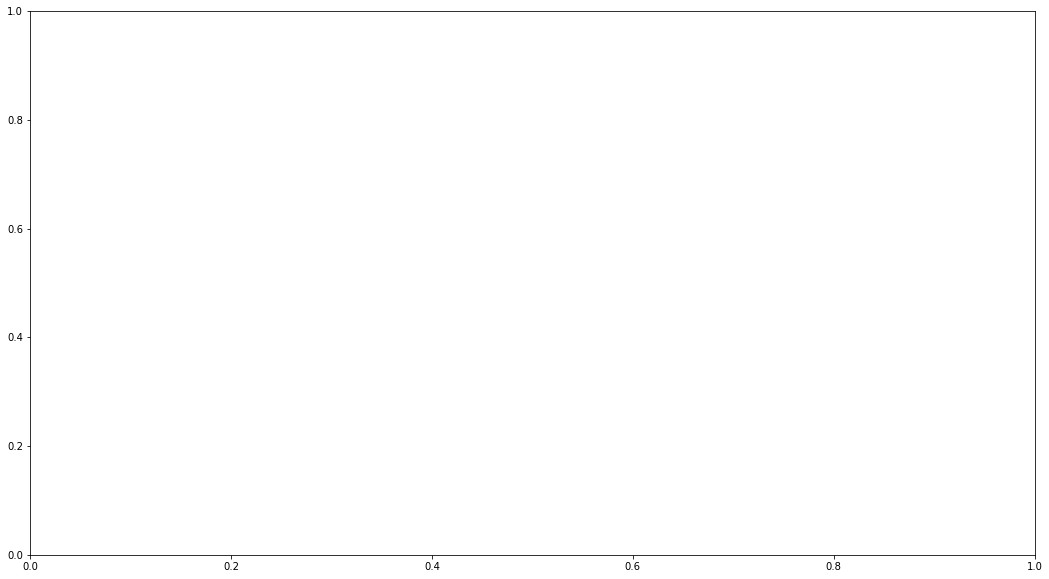

In [28]:
tupa = gpam()
epochs, bn, bs, lr, new_h, rep, optim = \
tuple(tupa[i] for i in list(range(0, 4))+[6,10,12])        
plt.rcParams["figure.figsize"] = (18,10)
linestyles = ['-', '--', '-.', ':', '-', '--',\
              '-.', ':', '-', '--', '-.', ':']
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
fig = plt.figure()
axes = plt.gca()
#    labels_text = [['t', 'v'], ['t rand input', 'v rand input'], \
#                   ['t rand output', 'v rand output'], ['t rand both', 'v rand both'],]
#labels_text = [['t', 'v'], ['$\widetilde{t}$', '$\widetilde{v}$']]*2 
labels_text =  [['t el', 'v el'], \
               ['$\widetilde{t}$ el', '$\widetilde{v}$ el']]
#     for i in range(len(labels_text)):
#         for j in range(len(labels_text[i])):
#             labels_text[i][j] += ' SH' if i < 2 else ' el'
#     for trt in range(lossb.shape[1]):
for isr in range(lossb.shape[0]):
#            cura = np.asarray(lossb[isr,trt])
    plt.plot(np.arange(lossb.shape[2]), \
             lossb[isr,trt], label=labels_text[isr][trt], \
             color = colors[isr], linestyle=linestyles[trt], \
             linewidth=3)
axes.set_xticks(np.arange(0, int(lossb[0][0].shape[0]*1.1),\
                          max(int(lossb[0][0].shape[0]*0.1),1)))
#axes.set_yticks(np.arange(ymin, ymax, 1))
plt.grid()
plt.legend(bbox_to_anchor=(1.05, 1), loc='best', borderaxespad=0., \
           fontsize = 24)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.autoscale(enable=True, axis='both', tight=None)
#     ymin, ymax = 0, 2
#     axes.set_ylim([ymin,ymax])
plt.xlabel('Epoch', fontsize=24)
plt.ylabel('MSE Loss', fontsize=24)
plt.title('Learning curve \n', fontsize=24)
fig.text(.5, -.1, 't - training, v - validation, '\
'SH - spherical harmonics, \n el - synthetic ellipses, '\
                   '$\widetilde{x}$ - random numbers on input',\
         ha='right',fontsize=24)

In [35]:
new_h = 100
bs = 1
lossb, timel, load_time = runtrain(new_h, bs)

0 0 0 SH
00:00:25,00:00:19,00:00:06,00:00:00,
1 0 1 SH
00:00:00,
0 1 2 el
00:00:02,
1 1 3 el
00:00:00,


[]

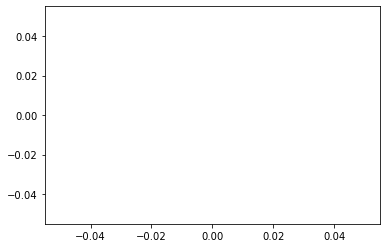

In [24]:
plt.plot()

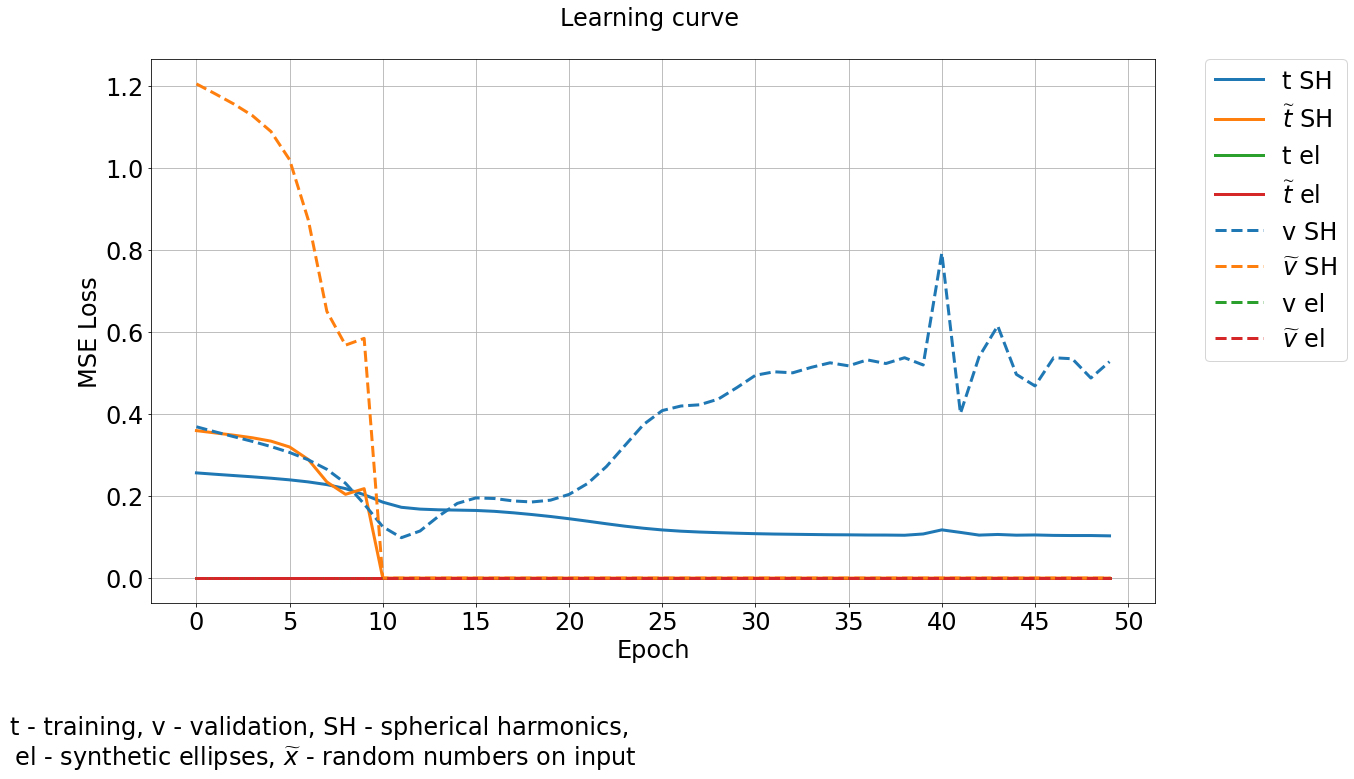

In [26]:
traplot(timel)

In [29]:
#new_h = 100
hl = [100, 200, 400, 550]
#hl = [400, 600, 800]
for new_h in hl:
    try:
        lossb, timel = runtrain(new_h)
#        new_h += 50
    except:
        print(new_h)
        break
print('done')

0 0 0 SH
00:00:01,1 0 1 SH
0 1 2 el
00:00:00,1 1 3 el
0 0 0 SH
00:00:02,1 0 1 SH
0 1 2 el
00:00:00,1 1 3 el
0 0 0 SH
00:00:02,1 0 1 SH
0 1 2 el
00:00:00,1 1 3 el
done


In [34]:
#new_h = 100
#hl = [100, 200, 400, 550]
bsl = [1, 2, 5, 10]
bsl = [10, 20, 50, 100]
#hl = [400, 600, 800]
for bs in bsl:
    try:
        lossb, timel = runtrain(550, bs)
#        new_h += 50
    except:
        print(bs)
        break
print('done')

0 0 0 SH
00:00:14,00:00:00,1 0 1 SH
0 1 2 el
00:00:00,1 1 3 el
0 0 0 SH
00:00:28,00:00:00,1 0 1 SH
0 1 2 el
00:00:00,1 1 3 el
0 0 0 SH
00:01:10,00:00:00,1 0 1 SH
0 1 2 el
00:00:01,1 1 3 el
0 0 0 SH
00:02:24,00:00:00,1 0 1 SH
0 1 2 el
00:00:02,1 1 3 el
done


In [25]:
lossb, timel = runtrain(bs)


NameError: name 'bs' is not defined

In [ ]:
traplot(timel)

## pam - SH regression hyperparameters

In [20]:
def pam(tupa):
    dtp, randin, gtup = tupa
    if dtp == 'SH':
        crop_h, new_h, ampl = tuple(gtup[i] for i in list(range(5, 8)))
        composed = transforms.Compose([CmsCrop(crop_h),Rescale(new_h),AmpCrop(ampl),\
                                   Minmax(tmean[:,:ampl]),\
                                    ToTensor(device)])
        dataset = FaceLandmarksDataset(csv_file=mainpath+'/sh_paramters.csv',
                                                   root_dir=mainpath,
                                                   transform=composed)
        C_in = 3
        ratio = 1.8
        ft = None #circle 3, ellipse 4, sphere 4, ellipsoid 6, angled ellipse 5, angled ellipsoid 7 
        n = None #number of objects per image 
        ovl = None
        gs = None
    elif dtp == 'el':
        bn, bs, new_h = tuple(gtup[i] for i in [1,2,6]) 
        C_in = 1
        ratio = 1
        ft = 'circle' #circle 3, ellipse 4, sphere 4, ellipsoid 6, angled ellipse 5, angled ellipsoid 7 
        n = 1 #number of objects per image 
        ovl = 0
        gs = 1    
        dataset = EllipseDataset((new_h, ft, n, gs, ovl, randin), bn*bs)        
    return(dataset, C_in, ratio, ft, n, ovl, gs, randin, dtp)

## traplot - Draw a plot of the training curve

In [25]:
def traplot(timel):
#     tupa = gpam+pam()
#     epochs, bn, bs, lr, modelname, \
#            crop_h, new_h, ampl, m_kernel, m_stride, \
#            rep, hidden_dim, optim, testf, valf = gpam()
    tupa = gpam()
    #     0 epochs, 1 bn, 2 bs, 3 lr, 4 modelname, \
#            5 crop_h, 6 new_h, 7 ampl, 8 m_kernel, 9 m_stride, \
#            10 rep, 11 hidden_dim, 12 optim, 13 testf, 14 valf,\
#     15 dataset, 16 C_in, 17 ratio, 18 ft, 19 n, 20 ovl, 21 gs, 22 randin = tupa
# 0, 1, 2, 3, 6, 10, 12
    epochs, bn, bs, lr, new_h, rep, optim = \
    tuple(tupa[i] for i in list(range(0, 4))+[6,10,12])        
    plt.rcParams["figure.figsize"] = (18,10)
    linestyles = ['-', '--', '-.', ':', '-', '--',\
                  '-.', ':', '-', '--', '-.', ':']
    colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
    fig = plt.figure()
    axes = plt.gca()
#    labels_text = [['t', 'v'], ['t rand input', 'v rand input'], \
#                   ['t rand output', 'v rand output'], ['t rand both', 'v rand both'],]
    #labels_text = [['t', 'v'], ['$\widetilde{t}$', '$\widetilde{v}$']]*2 
    labels_text = [['t SH', 'v SH'], \
                   ['$\widetilde{t}$ SH', '$\widetilde{v}$ SH'], 
                  ['t el', 'v el'], \
                   ['$\widetilde{t}$ el', '$\widetilde{v}$ el']]
#     for i in range(len(labels_text)):
#         for j in range(len(labels_text[i])):
#             labels_text[i][j] += ' SH' if i < 2 else ' el'
    for trt in range(lossb.shape[1]):
        for isr in range(lossb.shape[0]):
#            cura = np.asarray(lossb[isr,trt])
            plt.plot(np.arange(lossb.shape[2]), \
                     lossb[isr,trt], label=labels_text[isr][trt], \
                     color = colors[isr], linestyle=linestyles[trt], \
                     linewidth=3)
    axes.set_xticks(np.arange(0, int(lossb[0][0].shape[0]*1.1),\
                              max(int(lossb[0][0].shape[0]*0.1),1)))
    #axes.set_yticks(np.arange(ymin, ymax, 1))
    plt.grid()
    plt.legend(bbox_to_anchor=(1.05, 1), loc='best', borderaxespad=0., \
               fontsize = 24)
    plt.xticks(fontsize=24)
    plt.yticks(fontsize=24)
    plt.autoscale(enable=True, axis='both', tight=None)
#     ymin, ymax = 0, 2
#     axes.set_ylim([ymin,ymax])
    plt.xlabel('Epoch', fontsize=24)
    plt.ylabel('MSE Loss', fontsize=24)
#     plt.savefig('plot output/'+\
#                 'size='+str(new_h)+\
#                 'bn'+str(bn)+\
#                 'bs'+str(bs)+\
#                 'epochs'+str(epochs)+\
#                 'layers'+rep+\
#                 'lr'+str(lr)+\
#                 'optimizer'+str(optim)+\
#                 'etime'+format(timel,".2f")+\
#                 '.png', bbox_inches='tight')
    plt.title('Learning curve \n', fontsize=24)
    fig.text(.5, -.1, 't - training, v - validation, '\
    'SH - spherical harmonics, \n el - synthetic ellipses, '\
                       '$\widetilde{x}$ - random numbers on input',\
             ha='right',fontsize=24)
    plt.show()

In [20]:
lossb, timel = runtrain()

0 0 0 SH
00:02:22,00:02:11,00:02:01,00:01:46,00:01:38,00:01:24,00:01:17,00:01:10,00:00:56,00:00:49,00:00:35,00:00:28,00:00:14,00:00:07
00:00:00,
1 0 1 SH
00:00:20,00:00:13,00:00:07,
0 1 2 el
00:00:02,
1 1 3 el
00:00:00,


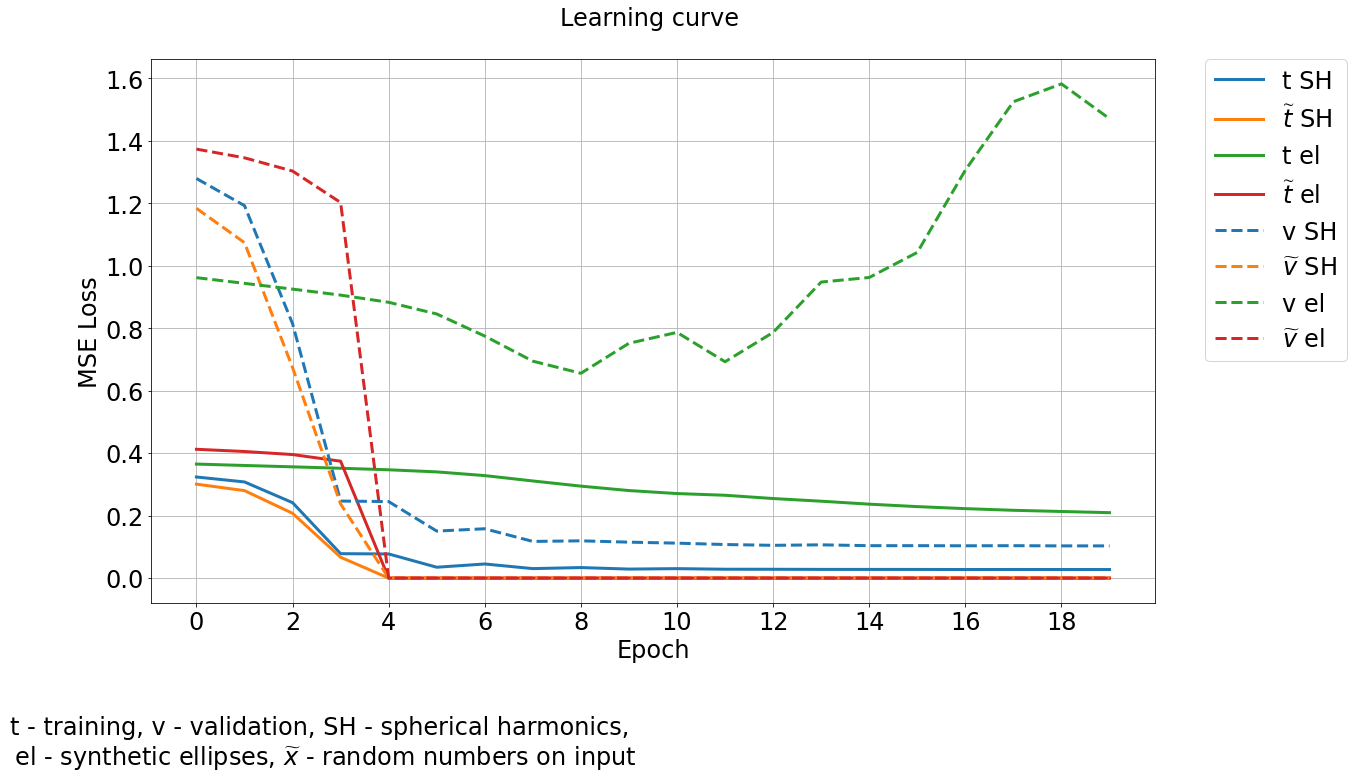

In [21]:
traplot(timel)